In [60]:
import torch
import esm
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pandas as pd
import numpy as np
import os
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from multiprocessing import Pool

In [ ]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

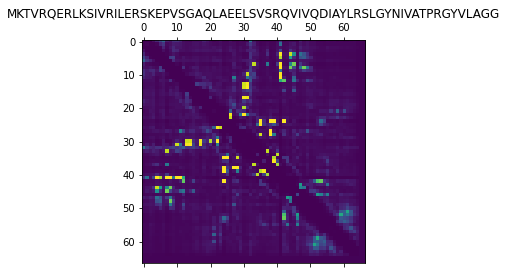

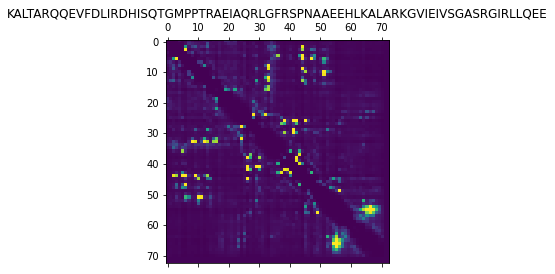

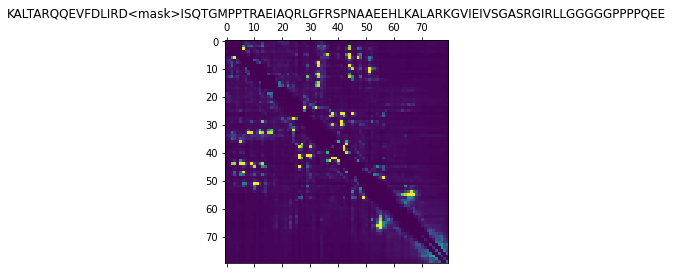

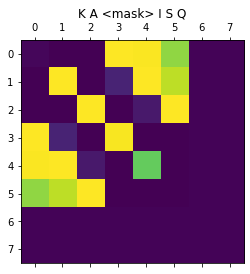

In [26]:
# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLGGGGGPPPPQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=True)
token_representations = results["representations"][6]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

In [27]:
import requests

url = "https://rest.uniprot.org/uniref/search"
params = {
    "query": "identity:0.5",
    "format": "json",
    "size": 10
}
resp = requests.get(url, params=params)
data = resp.json()

print(data)
for cluster in data['results']:
    print("Cluster:", cluster['id'])
    print("Representative:", cluster['representativeMember']['memberId'])


{'results': [{'id': 'UniRef50_A0A007', 'name': 'Cluster: MoeK5', 'updated': '2018-09-12', 'entryType': 'UniRef50', 'commonTaxon': {'scientificName': 'Streptomyces viridosporus', 'taxonId': 67581}, 'memberCount': 1, 'organismCount': 1, 'representativeMember': {'memberIdType': 'UniProtKB ID', 'memberId': 'A0A007_STRVD', 'organismName': 'Streptomyces viridosporus', 'organismTaxId': 67581, 'sequenceLength': 407, 'proteinName': 'MoeK5', 'accessions': ['A0A007'], 'uniref90Id': 'UniRef90_A0A007', 'uniref100Id': 'UniRef100_A0A007', 'uniparcId': 'UPI0000E5B243', 'seed': True, 'sequence': {'value': 'MGYIHTALKSAGFHHVIQVDTPALGLDSEGLRKLLADFEPDLVGVSTTTPGLPGAIEACEAAKSTGAKVILGGPHTEVYAHENLVHESIDYVGVGEGVTIMPELAEAMERGEEPEGIRGLVTRKHDGGAAPMVNLEEVGWPERAGLPMDRYYSIMAPRPFATMISSRGCPFKCSFCFKQAVDKKSMYRSPEDVVGEMTELKERWGVKEIMFYDDVFTLHRGRVREICGLIGETGLKVRWEAPTRVDLVPEPLLEAMAGAGCVRLRFGIEHGDSEILERMRKESDIQKIEKAVTSAHEAGIKGFGYFIVGWLGETREQFRRTVDLACRLPLDYASFYTATPLPGTPLHTESVAAGQIPPDYWDRFSCGASSTRGSGTWCRTRRSAPSGRTAPSSCAAPWSSRCC

In [1]:
from Bio import SeqIO
from tqdm import tqdm
import os
def filter_fasta(input_file, output_file, min_length=10, tax_filter=None, keyword=None, max_len=100, max_writes=1000):
    num_records = 0
    with open(output_file, "w") as out_handle:
        for record in tqdm(SeqIO.parse(input_file, "fasta")):
            desc = record.description

            # Apply your filters
            if len(record.seq) < min_length:
                continue
            if len(record.seq) > max_len:
                continue
            # if tax_filter and f"Tax={tax_filter}" not in desc:
            #     continue

            # if keyword and keyword.lower() not in desc.lower():
            #     continue

            # If it passes all filters, write it
            SeqIO.write(record, out_handle, "fasta")
            num_records += 1
            if num_records >= max_writes:
                break
            print("writing", record.id)

In [ ]:
# filter large file to smaller one
filter_fasta("../data/uniref50.fasta", "filtered_len_less_100.fasta")

In [2]:
def fasta_batches(file_path, batch_size=1):
    """
    Generator that yields batches of records from a FASTA file.
    Args:
        file_path (_type_): _description_
        batch_size (int, optional): _description_. Defaults to 1.

    """
    with open(file_path, "r") as handle:
        record_iter = SeqIO.parse(handle, "fasta")
        while True:
            batch = list(next(record_iter) for _ in range(batch_size))
            if not batch:
                break
            yield batch

In [3]:
#batch_1 = fasta_batches("../data/uniref50.fasta", 1)
batch_1 = fasta_batches("filtered_len_less_100.fasta", batch_size=10)
data_1 = []
for batch in batch_1:
    print(batch)
    for record in batch:
        print(record)
        # print(f"ID: {record.id}")
        # print(f"Description: {record.description}")
        # print(f"Sequence: {record.seq}\n")
        data_1.append((record.id, str(record.seq)))
    break

[SeqRecord(seq=Seq('ILGTKEYRKPEWVTQMEEMQEALR'), id='UniRef50_A0A6V7I9A3', name='UniRef50_A0A6V7I9A3', description='UniRef50_A0A6V7I9A3 PH domain-containing protein (Fragment) n=7 Tax=Braconidae TaxID=7402 RepID=A0A6V7I9A3_9HYME', dbxrefs=[]), SeqRecord(seq=Seq('YWNGKPMKHSSRIRQFCDFGFVIMEISPIYPEDSGE'), id='UniRef50_F8QXJ3', name='UniRef50_F8QXJ3', description='UniRef50_F8QXJ3 I-connectin (Fragment) n=5 Tax=Scylla paramamosain TaxID=85552 RepID=F8QXJ3_SCYPA', dbxrefs=[]), SeqRecord(seq=Seq('SEEVLNRKFTFVLDLHEGTWKAAKALLKTLQEVVPDKIHQIVIIKPDAFWEKRKSD'), id='UniRef50_A7T8B8', name='UniRef50_A7T8B8', description='UniRef50_A7T8B8 CRAL-TRIO domain-containing protein (Fragment) n=2 Tax=Nematostella vectensis TaxID=45351 RepID=A7T8B8_NEMVE', dbxrefs=[]), SeqRecord(seq=Seq('DDDDDDDDDDDDDDDN'), id='UniRef50_A0A821ISM6', name='UniRef50_A0A821ISM6', description='UniRef50_A0A821ISM6 Uncharacterized protein (Fragment) n=4 Tax=Protostomia TaxID=33317 RepID=A0A821ISM6_9BILA', dbxrefs=[]), SeqRecord(seq=Seq

In [68]:
# get all sequences from fasta file
def get_sequences_from_fasta(fasta_file):
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append(str(record.seq))
    return sequences

sequences = get_sequences_from_fasta("filtered_len_less_100.fasta")

In [70]:
# calculate the average feature for all sequences

features = {}
features['Hydrophobicity'] = 0.0
print(features)
    
for seq in sequences:
    if 'X' in seq or 'U' in seq:
        continue
    gravy = round(ProteinAnalysis(seq).gravy(), 2)
    features['Hydrophobicity'] += gravy

for key in features:
    features[key] = features[key] / len(sequences)

print(features)

{'Hydrophobicity': 0.0}
{'Hydrophobicity': -0.22592790218898437}


In [74]:
yo = []
for seq in sequences:
    if 'X' in seq or 'U' in seq:
        continue
    yo.append(round(ProteinAnalysis(seq).gravy(), 2))
print("mean: ", sum(yo) / len(yo))
print("std: ", np.std(yo))

mean:  -0.22806230318195866
std:  0.4534138773086728


In [76]:
# list out functions here (can't use lambda for multiprocessing)
def compute_gravy(seq):
    return (seq, ProteinAnalysis(seq).gravy())

def get_top_k_percent_feat(sequences, k=0.2, feature="gravy", output_file="top_sequences_gravy.csv"):
    """
    gets the top k percent of sequences based on a feature
    """
    assert k <= 1, "Top k must be less than 1"
    # Step 1: Filter out bad sequences
    valid_sequences = [s for s in sequences if 'X' not in s and 'U' not in s]

    # Step 2: Pick the right function
    if feature == "gravy":
        compute_feature = compute_gravy
    else:
        raise ValueError(f"Unknown feature: {feature}")

    # Step 2: Parallel feature computation
    with Pool() as pool:
        feature_scores = pool.map(compute_feature, valid_sequences)

    # Step 3: Sort and take top k%
    feature_scores.sort(key=lambda x: x[1], reverse=True)
    top_k = int(k * len(feature_scores))
    top_k_percent = feature_scores[:top_k]

    # Optional: Just the sequences
    top_sequences = [seq for seq, _ in top_k_percent]

    # save the top sequence in a csv file
    with open(output_file, "w") as f:
        for seq in top_sequences:
            f.write(seq + "\n")

get_top_k_percent_feat(sequences, k=0.1, feature="gravy")

In [11]:
batch_labels, batch_strs, batch_tokens = batch_converter(data_1)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=True)
token_representations = results["representations"][6]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data_1, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

NameError: name 'batch_converter' is not defined

In [ ]:
token_representation

tensor([[[ 2.4158e-01,  6.3405e-01,  2.8336e-01,  ...,  8.0860e-01,
          -3.8646e-02, -5.3292e-01],
         [ 2.7657e-01,  3.0062e-02,  3.0011e-01,  ..., -4.0664e-02,
           1.0321e-01, -1.2341e-01],
         [ 8.4466e-02, -1.5548e-01,  2.3214e-01,  ...,  2.8563e-01,
           1.6947e-02, -5.4177e-02],
         ...,
         [ 1.2359e-01, -1.8218e-01,  2.0750e-01,  ...,  5.3772e-02,
           6.4729e-02, -5.1833e-02],
         [ 2.0860e-01, -1.8127e-01,  3.0726e-01,  ...,  1.5711e-01,
           1.8963e-01, -3.4865e-02],
         [ 2.2354e-01, -2.3203e-01,  3.1020e-01,  ...,  1.6229e-01,
           2.1218e-01, -6.6319e-02]],

        [[ 1.6900e-01,  5.9973e-01,  1.9413e-01,  ...,  9.5296e-01,
          -4.1035e-02, -5.0708e-01],
         [-1.9192e-01,  2.2702e-01,  5.4962e-02,  ...,  2.7360e-01,
           2.1676e-01, -4.6859e-01],
         [-2.8732e-02, -1.3085e-01,  2.0647e-01,  ...,  2.9913e-01,
           9.3068e-02,  2.3619e-01],
         ...,
         [ 1.9043e-01, -2